# igv variant classifier

In [5]:
from fastai.vision import *

In [56]:
path = Path('/projects/da_workspace/szspace/data/giab/images')

In [57]:
classes = ['positives','negatives']

In [31]:
# verify_images?
get_transforms?

In [11]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [33]:
doc(get_transforms)

In [58]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.2,        
                                  ds_tfms=get_transforms(do_flip=False,max_rotate=None, max_zoom=1., max_warp=None, 
                                                         max_lighting=None,p_affine=0,p_lighting=0 ), 
                                  size=512, bs=32, 
                                  num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [59]:
data.classes

['negatives', 'positives']

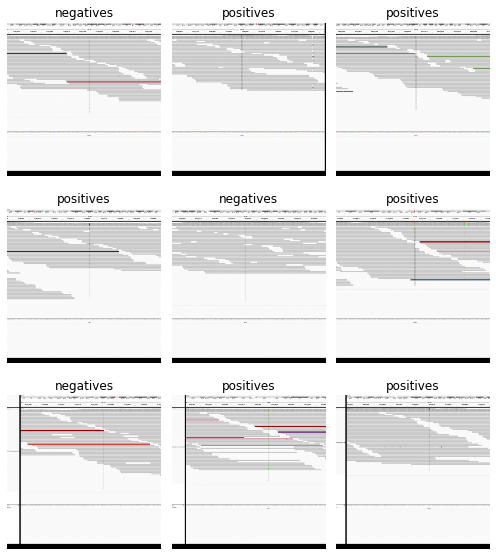

In [60]:
data.show_batch(rows=3, figsize=(7,8))

In [61]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['negatives', 'positives'], 2, 3203, 800)

## Train model

In [62]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [63]:
learn.fit_one_cycle(4, max_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.152966,0.080805,0.975000,00:51
1,0.071162,1.530589,0.571250,00:50
2,0.036133,0.022065,0.997500,00:49
3,0.011734,0.019149,0.996250,00:49


In [64]:
learn.save('stage-1')

In [65]:
learn.unfreeze()

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


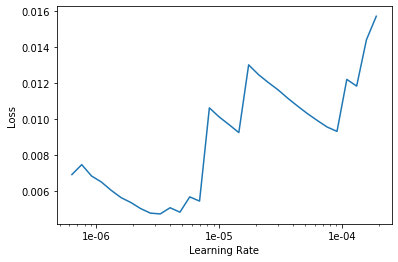

In [67]:
learn.recorder.plot()

In [ ]:
# If the plot is not showing try to give a start and end learning rate# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [68]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.014406,0.016857,0.997500,01:06
1,0.008175,0.016699,0.998750,01:07


In [69]:
learn.save('stage-2')

## Interpretation

In [70]:
learn.load('stage-2');

In [71]:
interp = ClassificationInterpretation.from_learner(learn)

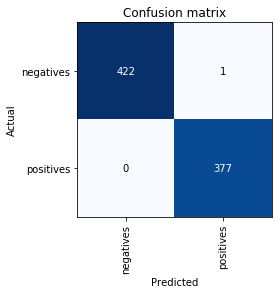

In [72]:
interp.plot_confusion_matrix()

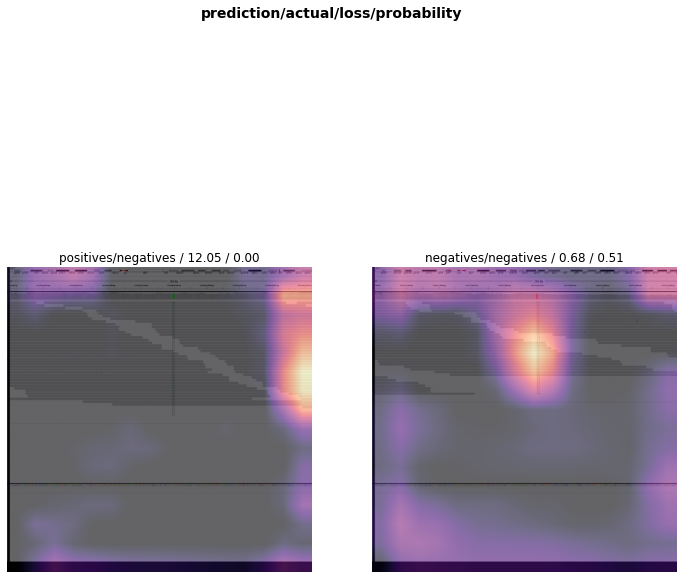

In [77]:
interp.plot_top_losses(2)

# train with 256x256 size image

In [52]:
learn.data

ImageDataBunch;

Train: LabelList (3203 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negatives,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/giab/images;

Valid: LabelList (800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negatives,positives,positives,negatives,positives
Path: /projects/da_workspace/szspace/data/giab/images;

Test: None

In [53]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.026151,0.073532,0.017500,00:16
1,0.019644,0.065938,0.013750,00:16


## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [12]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [13]:
defaults.device = torch.device('cpu')

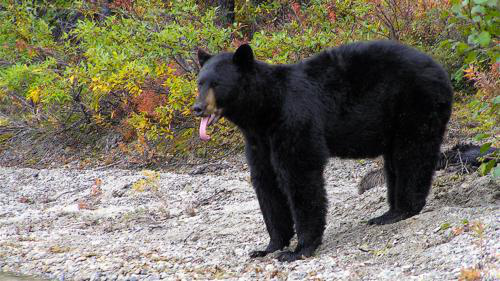

In [14]:
img = open_image(path/'black'/'00000021.jpg')
img

In [15]:
learn = load_learner(path)

pred_class,pred_idx,outputs = learn.predict(img)
pred_class